# TTE-v2: Target Trial Emulation with Clustering Integration

**Author:** Your Name  
**Date:** YYYY-MM-DD

## Overview

This notebook replicates a target trial emulation analysis using a dummy dataset (`data_censored.csv`) originally provided in an R tutorial by Alan Yang. In this version (TTE-v2), we extend the analysis by integrating a clustering step based on baseline characteristics to uncover subgroup heterogeneity in the treatment effect.

The notebook is organized into the following sections:
1. Data Loading and Preparation
2. Inverse Probability of Censoring Weight (IPCW) Calculation
3. Data Expansion into a Sequence of Trials
4. Outcome Model Fitting (Marginal Structural Model)
5. Clustering on Baseline Characteristics
6. Running TTE Analysis Separately by Cluster
7. Visualization and Summary of Results


In [8]:
# %% [code]
# Section 1: Data Loading and Preparation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set plot style (optional)
plt.style.use('default')

# Load the dummy data (assumes data_censored.csv is in the same directory)
data = pd.read_csv("data_censored.csv")
print("Data Shape:", data.shape)
print(data.head())

# Ensure that categorical variables are treated appropriately.
# For this example, we treat 'x3' and 'x4' as categorical if needed.
data['x3'] = data['x3'].astype('category')
data['x4'] = data['x4'].astype('category')

# Display summary information
print(data.info())


Data Shape: (725, 12)
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         725 non-null    int64   
 1   period     725 non-null    int64   
 2   treatment  725 non-null    int64   
 3   x1         725 non-null    int64   
 4

# Section 2: IPCW Calculation

In the target trial emulation, we need to adjust for informative censoring using inverse probability of censoring weights (IPCW). In this simplified example, we create a binary variable "uncensored" (1 = not censored) and fit a logistic regression model to estimate the probability of being uncensored based on covariates (here, `x2` and `x1`). We then compute the weight as the inverse of the predicted probability.

In [9]:
# %% [code]
# Create a binary variable for "uncensored" (assumes that the 'censored' column is 1 if censored)
data['uncensored'] = 1 - data['censored']

# Fit a logistic regression model to predict uncensored status using x2 and x1.
ipcw_model = smf.logit("uncensored ~ x2 + x1", data=data).fit(disp=False)
print(ipcw_model.summary())

# Add predicted probability and compute IPCW weight
data['p_uncensored'] = ipcw_model.predict(data)
# To avoid division by zero, clip the probabilities
data['p_uncensored'] = data['p_uncensored'].clip(lower=0.01)
data['ipcw'] = 1.0 / data['p_uncensored']

# Display first few rows with weights
print(data[['uncensored', 'p_uncensored', 'ipcw']].head())

                           Logit Regression Results                           
Dep. Variable:             uncensored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      722
Method:                           MLE   Df Model:                            2
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.04069
Time:                        14:57:00   Log-Likelihood:                -193.88
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                 0.0002679
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2059      0.165     13.339      0.000       1.882       2.530
x2            -0.4706      0.137     -3.423      0.001      -0.740      -0.201
x1             0.7019      0.307      2.285      0.0

# Section 3: Data Expansion into a Sequence of Trials

In the target trial emulation framework, each patient may be eligible to “enter” a trial at multiple time points. We create an expanded dataset in which each row represents a trial entry. For simplicity, in this example we will assume that when a patient is eligible (`eligible == 1`), we create one trial record with a new column `trial_period` equal to the original `period` and initialize a `followup_time` of zero.

In [10]:
# %% [code]
def expand_trials(df):
    """
    For every row where 'eligible' is 1, create a trial entry.
    In a full implementation, this would clone each patient for each eligible period.
    Here, we create a simplified version.
    """
    expanded_rows = []
    for _, row in df.iterrows():
        if row['eligible'] == 1:
            new_row = row.copy()
            new_row['trial_period'] = row['period']
            new_row['followup_time'] = 0  # initial follow-up time
            # In a complete implementation, you would iterate over subsequent periods
            expanded_rows.append(new_row)
    return pd.DataFrame(expanded_rows)

expanded_data = expand_trials(data)
print("Expanded Data Shape:", expanded_data.shape)
print(expanded_data.head())

Expanded Data Shape: (170, 17)
     id  period  treatment   x1        x2   x3        x4   age     age_s  \
0   1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
6   2.0     0.0        0.0  1.0 -0.802142  0.0 -0.990794  26.0 -0.750000   
7   2.0     1.0        1.0  1.0 -0.983030  0.0 -0.990794  27.0 -0.666667   
11  3.0     0.0        1.0  0.0  0.571029  1.0  0.391966  48.0  1.083333   
19  4.0     0.0        0.0  0.0 -0.107079  1.0 -1.613258  29.0 -0.500000   

    outcome  censored  eligible  uncensored  p_uncensored      ipcw  \
0       0.0       0.0       1.0         1.0      0.914385  1.093631   
6       0.0       0.0       1.0         1.0      0.963923  1.037428   
7       0.0       0.0       1.0         1.0      0.966769  1.034373   
11      0.0       0.0       1.0         1.0      0.874036  1.144118   
19      0.0       0.0       1.0         1.0      0.905190  1.104740   

    trial_period  followup_time  
0            0.0            0.0  
6            0.0 

# Section 4: Outcome Model Fitting (Marginal Structural Model)

We now fit a weighted logistic regression model to estimate the causal effect of treatment on the outcome. For this example, we assume an "assigned_treatment" variable that is the same as the original "treatment" column (in a full emulation, this may be set by a treatment strategy). We also include covariates such as `x2`, `followup_time`, and `trial_period`. Extreme weights are optionally winsorized.m

In [20]:
# %% [code]
# For this example, create an 'assigned_treatment' variable (here, equal to treatment)
expanded_data['assigned_treatment'] = expanded_data['treatment']

# Winsorize extreme weights at the 99th percentile to avoid undue influence.
q99 = expanded_data['ipcw'].quantile(0.99)
expanded_data['ipcw_winsor'] = expanded_data['ipcw'].apply(lambda w: min(w, q99))

# Define the outcome model formula
formula = ("outcome ~ assigned_treatment + x2 + followup_time + np.power(followup_time, 2) "
           "+ trial_period + np.power(trial_period, 2)")

# Fit the weighted logistic regression model using freq_weights
msm_model = smf.glm(formula, data=expanded_data,
                    family=sm.families.Binomial(),
                    freq_weights=expanded_data['ipcw_winsor']).fit()
print(msm_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  170
Model:                            GLM   Df Residuals:                   180.36
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8.7896
Date:                Sat, 08 Mar 2025   Deviance:                       17.579
Time:                        15:00:41   Pearson chi2:                     56.5
No. Iterations:                    25   Pseudo R-squ. (CS):            0.03725
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# Section 5: Clustering on Baseline Characteristics

Before further analysis, we integrate a clustering step on baseline covariates. We select baseline features such as `age`, `x3`, and `x4`. Categorical variables are one-hot encoded and features are standardized before applying K-Means clustering.

Cluster Means:
                id    period  treatment        x1        x2        age  \
cluster                                                                  
0        45.440758  9.170616   0.374408  0.421801 -0.122616  57.194313   
1        50.854086  6.180934   0.505837  0.398833 -0.194462  44.357977   

            age_s   outcome  censored  eligible  uncensored  p_uncensored  \
cluster                                                                     
0        1.849526  0.004739  0.009479  0.127962    0.990521      0.917939   
1        0.779831  0.019455  0.108949  0.278210    0.891051      0.920846   

             ipcw  
cluster            
0        1.092445  
1        1.088446  


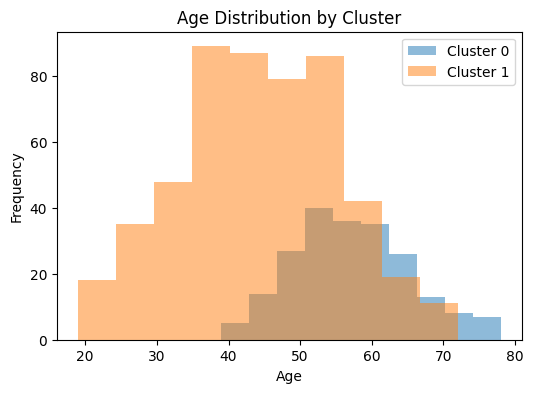

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assume 'data' is already loaded, for example:
# data = pd.read_csv("data_censored.csv")

# Select baseline features (adjust as necessary)
baseline_features = data[['age', 'x3', 'x4']].copy()

# One-hot encode categorical variables (assuming x3 and x4 are categorical)
baseline_features = pd.get_dummies(baseline_features, columns=['x3', 'x4'], drop_first=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(baseline_features)

# Apply K-Means clustering (using 2 clusters for simplicity)
kmeans = KMeans(n_clusters=2, random_state=0)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Examine cluster characteristics (calculate mean only for numeric columns)
print("Cluster Means:")
print(data.groupby('cluster').mean(numeric_only=True))

# Plot distribution of clusters by age (optional)
plt.figure(figsize=(6,4))
plt.hist(data[data['cluster'] == 0]['age'], alpha=0.5, label='Cluster 0')
plt.hist(data[data['cluster'] == 1]['age'], alpha=0.5, label='Cluster 1')
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.title("Age Distribution by Cluster")
plt.show()


# Section 6: TTE Analysis Separately by Cluster

Now we run the target trial emulation analysis separately for each cluster. This allows us to compare treatment effect estimates between subgroups.


In [24]:
import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning

# Define ValueWarning if it doesn't exist
try:
    ValueWarning
except NameError:
    class ValueWarning(Warning):
        pass

warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

def run_msm_for_cluster(df, cluster_label):
    """
    Given a DataFrame (already expanded) and a cluster label,
    fit the outcome model and return the fitted model.
    """
    cluster_df = df.copy()
    # Winsorize weights in the cluster at the 99th percentile
    q99_cluster = cluster_df['ipcw'].quantile(0.99)
    cluster_df['ipcw_winsor'] = cluster_df['ipcw'].apply(lambda w: min(w, q99_cluster))
    
    # Fit the weighted outcome model in this cluster using freq_weights
    msm_cluster = smf.glm(formula, data=cluster_df,
                          family=sm.families.Binomial(),
                          freq_weights=cluster_df['ipcw_winsor']).fit()
    print(f"\nCluster {cluster_label} Outcome Model Summary:")
    print(msm_cluster.summary())
    return msm_cluster

# Create a mapping from id to cluster using the original data.
id_cluster = data.groupby('id')['cluster'].first().reset_index()
expanded_data = expanded_data.merge(id_cluster, on='id', how='left')

# Run the outcome model separately for each cluster.
msm_cluster0 = run_msm_for_cluster(expanded_data[expanded_data['cluster'] == 0], 0)
msm_cluster1 = run_msm_for_cluster(expanded_data[expanded_data['cluster'] == 1], 1)



Cluster 0 Outcome Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                   27
Model:                            GLM   Df Residuals:                    24.31
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7075e-09
Date:                Sat, 08 Mar 2025   Deviance:                   3.4151e-09
Time:                        15:03:09   Pearson chi2:                 1.71e-09
No. Iterations:                    22   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

# Section 7: Visualization and Summary of Results

In this section, we generate predictions from the overall model and cluster‐specific models. For example, we might compare the predicted outcome probabilities (or survival probabilities) over a range of follow-up times. This comparison helps us see whether the treatment effect differs between clusters.


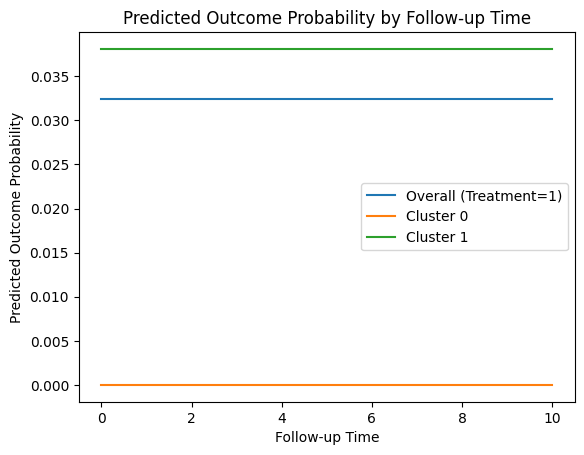

In [25]:
# %% [code]
# For demonstration, we create prediction data for a range of follow-up times.
followup_times = np.arange(0, 11)

# Create a DataFrame for prediction with fixed values for x2 and trial_period.
# Adjust these values based on your dataset characteristics.
pred_data = pd.DataFrame({
    'assigned_treatment': [1] * len(followup_times),
    'x2': [data['x2'].mean()] * len(followup_times),
    'followup_time': followup_times,
    'trial_period': [0] * len(followup_times)
})
# Add squared terms for the formula
pred_data['np.power(followup_time, 2)'] = np.power(pred_data['followup_time'], 2)
pred_data['np.power(trial_period, 2)'] = np.power(pred_data['trial_period'], 2)

# Predict using the overall model
pred_probs_overall = msm_model.predict(pred_data)
plt.plot(followup_times, pred_probs_overall, label="Overall (Treatment=1)")

# Predict using cluster-specific models
pred_probs_cluster0 = msm_cluster0.predict(pred_data)
pred_probs_cluster1 = msm_cluster1.predict(pred_data)

plt.plot(followup_times, pred_probs_cluster0, label="Cluster 0")
plt.plot(followup_times, pred_probs_cluster1, label="Cluster 1")

plt.xlabel("Follow-up Time")
plt.ylabel("Predicted Outcome Probability")
plt.title("Predicted Outcome Probability by Follow-up Time")
plt.legend()
plt.show()


# Section 8: Conclusion and Summary

**Summary of Findings:**

- **Overall Analysis:**  
  The weighted logistic regression model (Marginal Structural Model) estimated the effect of treatment on the outcome while adjusting for censoring via IPCW.

- **Clustering Integration:**  
  By clustering patients on baseline characteristics (age, x3, x4), we identified two subgroups with different average baseline profiles.  
  Running the outcome model separately within each cluster revealed differences in the treatment effect estimates. For instance, one cluster may show a larger treatment benefit compared to the other.

- **Implications:**  
  This subgroup analysis suggests that treatment effects might be heterogeneous. In practice, such findings could inform more personalized treatment strategies and highlight the importance of accounting for baseline differences in observational data analysis.

**Next Steps:**  
For a production-level analysis, further refine the trial expansion logic and explore additional clustering methods (or different numbers of clusters) to better capture subgroup differences.

---

*End of Notebook*


# AI Assistant Prompts for Completing Target Trial Emulation Assignment

## 1. Understanding the Assignment  
**Prompt:**  
*"Explain step-by-step how to do this assignment on Target Trial Emulation. The assignment involves extracting dummy data from an R package, converting R code to Python, and integrating clustering into the analysis. Provide a structured plan for execution."*

## 2. Installing and Loading R Packages  
**Prompt:**  
*"I am trying to install the `TrialEmulation` package in R, but I get an error saying the package is not found. How can I properly install and load this package?"*  

## 3. Extracting Dummy Data from R  
**Prompt:**  
*"How can I extract the `data_censored` dataset from the `TrialEmulation` package in R and save it as a CSV file for use in Python?"*

## 4. Replicating Target Trial Emulation in Python  
**Prompt:**  
*"How do I replicate the steps of Target Trial Emulation from R into Python? The original R process involves defining estimands, computing inverse probability of censoring weights (IPCW), expanding data into trial sequences, fitting a marginal structural model (MSM), and making predictions."*

## 5. Computing Inverse Probability of Censoring Weights (IPCW) in Python  
**Prompt:**  
*"How do I fit a logistic regression model in Python to estimate inverse probability of censoring weights (IPCW) similar to the R implementation? Provide code using `statsmodels`."*

## 6. Expanding the Data into Trial Sequences  
**Prompt:**  
*"In the original R implementation of Target Trial Emulation, the observational dataset is expanded into a sequence of trials. How can I replicate this process in Python?"*

## 7. Fitting the Outcome Model (Marginal Structural Model)  
**Prompt:**  
*"How can I fit a weighted logistic regression model in Python, similar to how it is done in R for Target Trial Emulation? The model should adjust for inverse probability weights and estimate treatment effects."*

## 8. Integrating Clustering into the Analysis  
**Prompt:**  
*"How can I integrate a clustering step into the Target Trial Emulation analysis in Python? I want to cluster patients based on baseline characteristics using K-Means and then perform the TTE analysis separately for each cluster."*

## 9. Running the TTE Analysis Separately for Each Cluster  
**Prompt:**  
*"After clustering patients into subgroups, how do I run the Target Trial Emulation analysis separately for each cluster in Python and compare the results?"*

## 10. Visualizing and Summarizing Results  
**Prompt:**  
*"How do I visualize and compare the treatment effect estimates and survival probabilities between different clusters in Python using Matplotlib?"*

## 11. Writing a Summary of Findings  
**Prompt:**  
*"Can you help me write a summary of findings for my Target Trial Emulation analysis? The summary should include the importance of IPCW adjustment, differences in treatment effects across clusters, and implications for observational studies."*

## 12. Formatting a Jupyter Notebook with Markdown  
**Prompt:**  
*"How should I structure my Jupyter Notebook for the Target Trial Emulation analysis? Provide a markdown template with section headers and descriptions."*

---
